#Action Recognition Counting Shoes

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
from sklearn import manifold, datasets, cluster, mixture
from time import time
import warnings
import torch.nn.functional as F
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice
import torch
import torch.nn as nn
import copy
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import cv2
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import numpy as np
import time
import optuna
import torch.optim as optim

%matplotlib inline

In [2]:
import mediapipe as mp

2024-05-18 17:17:28.150079: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-18 17:17:34.635984: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [5]:
#keypoints using MP holistics
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils
# create meiapip detection function
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False
    results = model.process(image)
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return image, results

In [6]:
#draw landmarks
def draw_styled_landmarks(image, results):
    '''mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS,
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1),
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             )
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4),
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             )
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4),
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             )'''
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4),
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             )
    return image


In [7]:
def extract_keypoints(results):
    # Extracts x and y coordinates if pose landmarks are available
    if results.pose_landmarks:
        pose = np.array([[res.x, res.y] for res in results.pose_landmarks.landmark])
    else :
        pose = np.zeros((33, 3))
    return pose


In [8]:
path = "/home/wetu/bmo/My_work/smart_sense/action_recognition/data_collection/"
save_path = "/home/wetu/bmo/My_work/smart_sense/action_recognition/data_collection/data.npy"

In [11]:
data_q = []

# Initialize Holistic model from mediapipe
mp_holistic = mp.solutions.holistic

for directory in os.listdir(path):
    sub_path = os.path.join(path, directory)
    label = directory

    # Iterate over files in the subdirectory
    for file in os.listdir(sub_path):
        video_path = os.path.join(sub_path, file)
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            print(f"Failed to open video {video_path}")
            continue
        keypoints = []
        print(video_path)
        try:
            with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
                while True:
                    ret, frame = cap.read()
                    if not ret:
                        break
                    image, results = mediapipe_detection(frame, holistic)
                    image = draw_styled_landmarks(image, results)
                    keypoints.append(extract_keypoints(results))
        finally:
            cap.release()

        # Adjust keypoints length to 120 frames
        if len(keypoints) > 120:
            keypoints = keypoints[:120]
        elif len(keypoints) < 120:
            while len(keypoints) < 120:
                keypoints.append(np.zeros((33, 3)))

        data_q.append(keypoints)

cv2.destroyAllWindows()

/home/wetu/bmo/My_work/smart_sense/action_recognition/data_collection/pick_up/vlc-record-2024-05-04-11h46m39s-video01.mp4-.mp4


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


/home/wetu/bmo/My_work/smart_sense/action_recognition/data_collection/pick_up/vlc-record-2024-05-04-11h31m23s-video00.mp4-.mp4
/home/wetu/bmo/My_work/smart_sense/action_recognition/data_collection/pick_up/vlc-record-2024-05-13-13h32m50s-video05.mp4-.mp4
/home/wetu/bmo/My_work/smart_sense/action_recognition/data_collection/pick_up/vlc-record-2024-05-13-14h01m22s-video05.mp4-.mp4
/home/wetu/bmo/My_work/smart_sense/action_recognition/data_collection/pick_up/vlc-record-2024-05-04-11h40m02s-video00.mp4-.mp4
/home/wetu/bmo/My_work/smart_sense/action_recognition/data_collection/pick_up/vlc-record-2024-05-04-11h13m35s-video00.mp4-.mp4
/home/wetu/bmo/My_work/smart_sense/action_recognition/data_collection/pick_up/vlc-record-2024-05-04-11h49m34s-video01.mp4-.mp4
/home/wetu/bmo/My_work/smart_sense/action_recognition/data_collection/pick_up/vlc-record-2024-05-13-13h50m28s-video05.mp4-.mp4
/home/wetu/bmo/My_work/smart_sense/action_recognition/data_collection/pick_up/vlc-record-2024-05-04-11h32m23s-v

In [ ]:
print(len(data_q))

In [12]:
keypoints = np.array([keypoint for keypoint in data_q])
# This should already be a numpy array from previous steps

# Save the keypoints and labels
np.save('keypoints.npy', keypoints)

# Shuffle the array along the first axis
np.random.shuffle(keypoints)
np.save('worker_crop_nolabel.npy',keypoints)
# Now 'array' is shuffled along its first axis (99 elements shuffled)


In [10]:
keypoints = np.load("keypoints.npy")
print(keypoints.shape)

(99, 120, 33, 2)


In [9]:
keypoints = keypoints[:, ::4, :, :]

print(keypoints.shape)  # This should print (99, 40, 33, 2)


(99, 30, 33, 2)


(99, 120, 33, 2)
[120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120]


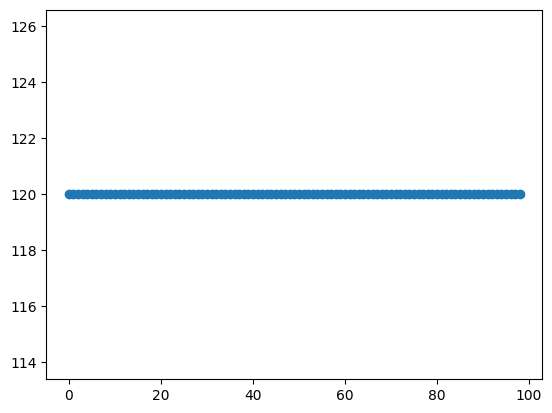

In [13]:
len_vid = []
print(keypoints.shape)
# Assuming each element of keypoints is a list of numbers or another array
for row in keypoints:
    len_vid.append(len(row))
print(len_vid)
indexes = list(range(len(len_vid)))
plt.scatter(indexes,len_vid)

In [10]:
total_length = 99  # This should match your actual data length

labels = np.zeros((total_length, 3))

# Assign the labels according to specified ranges
labels[:33, 0] = 1  # First 33 entries get label [1, 0, 0]
labels[33:66, 1] = 1  # Second 33 entries get label [0, 1, 0]
labels[66:, 2] = 1   # Last 33 entries get label [0, 0, 1]

print(labels.shape)


(99, 3)


In [11]:
keypoints = np.array(keypoints, dtype=np.float32)  # Ensure this is a float32 array
labels = np.array(labels, dtype=np.float32)        # Ensure this is a float32 array

# Check if any element is of type 'object'
if keypoints.dtype == object or labels.dtype == object:
    print("Data contains object types, needs cleaning or investigation.")

In [12]:
import torch
from torch.utils.data import Dataset, DataLoader

class KeypointDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data_item = self.data[idx]
        label_item = self.labels[idx]

        # Ensure the data is in the correct type before conversion
        if not isinstance(data_item, np.ndarray):
            data_item = np.array(data_item)

        data_item = data_item.reshape(30, -1)
        data_tensor = torch.from_numpy(data_item).float()  # Using from_numpy for better memory efficiency
        label_tensor = torch.from_numpy(label_item).float()

        return data_tensor, label_tensor


dataset = KeypointDataset(keypoints, labels)
data_loader = DataLoader(dataset, batch_size=10, shuffle=True)

# Test the DataLoader
for data, labels in data_loader:
    print('Data shape:', data.shape)  # Expected shape: [batch_size, 120, 66]
    print('Labels shape:', labels.shape)  # Expected shape: [batch_size, 3]
    break


Data shape: torch.Size([10, 30, 66])
Labels shape: torch.Size([10, 3])


In [17]:
'''class ActionRecognition(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, bidirectional=True):
        super(ActionRecognition, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional

        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, bidirectional=bidirectional)
        self.fc = nn.Linear(hidden_size * 2 if bidirectional else hidden_size, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers * (2 if self.bidirectional else 1), x.size(0), self.hidden_size).to(x.device)

        # Forward propagate GRU
        out, _ = self.gru(x, h0)  # out: tensor of shape (batch_size, seq_length, hidden_size*2 if bidirectional else hidden_size)
        out = self.dropout(out[:, -1, :])  # Extract last timestep

        # Decode the hidden state of the last time step
        out = self.fc(out)
        return out'''

'class ActionRecognition(nn.Module):\n    def __init__(self, input_size, hidden_size, num_layers, num_classes, bidirectional=True):\n        super(ActionRecognition, self).__init__()\n        self.hidden_size = hidden_size\n        self.num_layers = num_layers\n        self.bidirectional = bidirectional\n\n        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, bidirectional=bidirectional)\n        self.fc = nn.Linear(hidden_size * 2 if bidirectional else hidden_size, num_classes)\n        self.dropout = nn.Dropout(0.5)\n\n    def forward(self, x):\n        # Initialize hidden state with zeros\n        h0 = torch.zeros(self.num_layers * (2 if self.bidirectional else 1), x.size(0), self.hidden_size).to(x.device)\n\n        # Forward propagate GRU\n        out, _ = self.gru(x, h0)  # out: tensor of shape (batch_size, seq_length, hidden_size*2 if bidirectional else hidden_size)\n        out = self.dropout(out[:, -1, :])  # Extract last timestep\n\n        # Decode

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ActionRecognition(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, num_layers: int, num_classes: int = 3, bidirectional: bool = True):
        super(ActionRecognition, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional

        # Define a GRU layer
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, bidirectional=bidirectional)
        # Linear layer that maps the hidden state output dimension to num_classes
        self.fc = nn.Linear(hidden_size * 2 if bidirectional else hidden_size, num_classes)
        # Dropout for regularization
        self.dropout = nn.Dropout(0.3)

    def init_hidden(self, batch_size: int, device: torch.device):
        # Initialize hidden state with zeros
        num_directions = 2 if self.bidirectional else 1
        return torch.zeros(self.num_layers * num_directions, batch_size, self.hidden_size).to(device)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Initialize hidden state
        h0 = self.init_hidden(x.size(0), x.device)

        # Forward propagate the GRU
        out, _ = self.gru(x, h0)

        # Apply dropout to the output of the last time step
        out = self.dropout(out[:, -1, :])  # Take the output for the last time step

        # Pass the output of the last time step to the fully connected layer
        out = self.fc(out)

        # Apply softmax to the output layer
        out = F.softmax(out, dim=1)  # Use softmax for multi-class classification

        return out

# Example usage:
# model = ActionRecognition(input_size=128, hidden_size=256, num_layers=2)
# x = torch.randn(32, 10, 128)  # Batch of 32 sequences, each of length 10 with 128 features
# output = model(x)


In [17]:
num_epochs =5000
input_size = 66
learning_rate = 7e-3
hidden_size = 128
num_layers = 2
batch_size = 10

In [18]:
def train_model(model,criterion,optimizer, data_loaders,epochs):
  since = time.time()
  best_model_wts = copy.deepcopy(model.state_dict())
  best_loss = float('inf')
  losses = []
  model = model.to(device)
  for epoch in range(epochs):
    print(f'Epoch {epoch+1}/{epochs}')
    print('_'*20)
    model.train()
    running_loss = 0.0
    for inputs, labels in data_loaders:
        labels = labels.float().to(device)
        inputs = inputs.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        outputs = outputs.squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        #print(f"{loss.item()}\n")
        running_loss += loss.item() * inputs.size(0)  # Correctly accumulate loss here

    # Calculate average loss over the epoch outside the batch loop
    epoch_loss = running_loss / len(data_loaders.dataset)  # Assuming correct variable name
    losses.append(epoch_loss)
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        best_model_wts = copy.deepcopy(model.state_dict())
    print(f'Epoch Loss: {epoch_loss:.4f}')
  time_elapsed = time.time() - since
  print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
  print(f'Best val Loss: {best_loss:.4f}')

  # Load best model weights
  model.load_state_dict(best_model_wts)
  return model, losses

In [ ]:
import optuna
import torch.optim as optim

# Define the objective function for Optuna
def objective(trial):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    train_loader = DataLoader(dataset, batch_size=10, shuffle=True)

    input_size = 66
    hidden_size = trial.suggest_int("hidden_size", 64, 256,step=64)
    #num_layers = trial.suggest_int("num_layers", 1, 3)
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-4, log=True)
    
    model = ActionRecognition(input_size, hidden_size, num_layers).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    epoch_loss = train_model(model, criterion, optimizer, train_loader, num_epochs)
    return epoch_loss

# Create and run the Optuna study
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

print("Best trial:")
trial = study.best_trial

print(f"  Loss: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

In [ ]:
print(f"  Loss: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

In [19]:
model = ActionRecognition(input_size,hidden_size,num_layers)

In [20]:
criterion = torch.nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)


In [21]:
model, losses = train_model(model, criterion, optimizer,data_loader,num_epochs)
torch.save(model.state_dict(), './lstm_autoencoder_model.pt')

Epoch 1/5000
____________________
Epoch Loss: 0.6418
Epoch 2/5000
____________________
Epoch Loss: 0.6402
Epoch 3/5000
____________________
Epoch Loss: 0.6382
Epoch 4/5000
____________________
Epoch Loss: 0.6383
Epoch 5/5000
____________________
Epoch Loss: 0.6324
Epoch 6/5000
____________________
Epoch Loss: 0.6333
Epoch 7/5000
____________________
Epoch Loss: 0.6291
Epoch 8/5000
____________________
Epoch Loss: 0.6276
Epoch 9/5000
____________________
Epoch Loss: 0.6241
Epoch 10/5000
____________________
Epoch Loss: 0.6225
Epoch 11/5000
____________________
Epoch Loss: 0.6204
Epoch 12/5000
____________________
Epoch Loss: 0.6179
Epoch 13/5000
____________________
Epoch Loss: 0.6165
Epoch 14/5000
____________________
Epoch Loss: 0.6151
Epoch 15/5000
____________________
Epoch Loss: 0.6136
Epoch 16/5000
____________________
Epoch Loss: 0.6123
Epoch 17/5000
____________________
Epoch Loss: 0.6100
Epoch 18/5000
____________________
Epoch Loss: 0.6083
Epoch 19/5000
____________________
Ep

In [23]:
model_path = "/home/wetu/bmo/My_work/smart_sense/action_recognition/lstm_autoencoder_model.pt"
state_dict = torch.load(model_path)

# Step 3: Load the state dictionary into the model
model.load_state_dict(state_dict)

# Set the model to evaluation mode
model.eval()


ActionRecognition(
  (gru): GRU(66, 128, num_layers=2, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=256, out_features=3, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

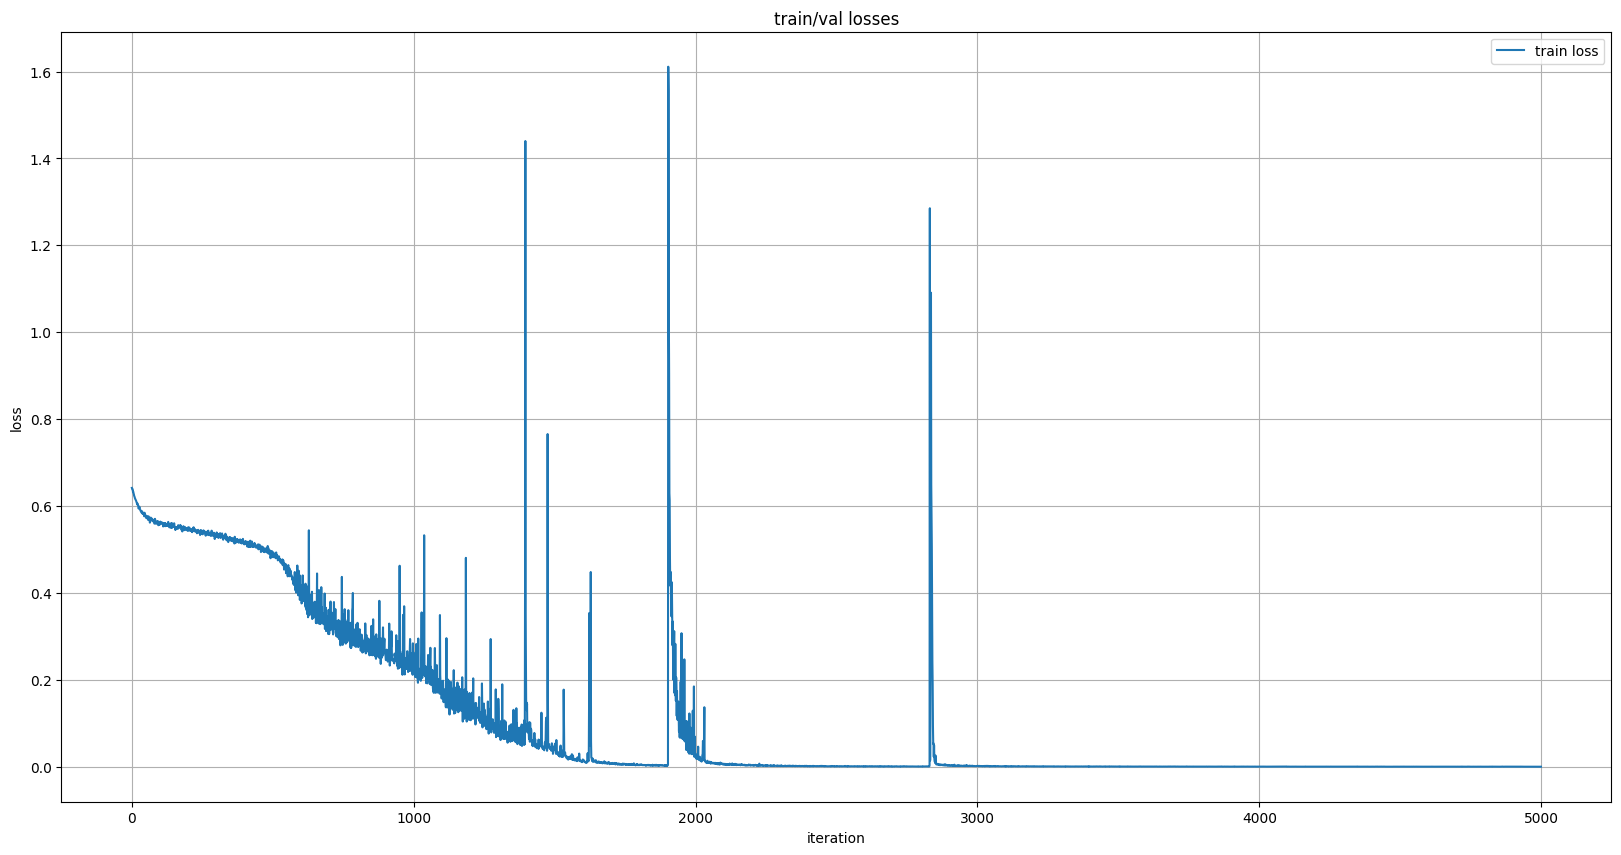

In [24]:

plt.figure(figsize=(20, 10))

#for phase in ['train', 'val']:
for phase in ['train']:
    plt.plot(losses, label='{} loss'.format(phase))

plt.legend()

plt.title('train/val losses')

plt.xlabel('iteration')
plt.ylabel('loss')

plt.grid(True)

In [31]:
import cv2
import mediapipe as mp
import numpy as np
import torch

video_path = '/home/wetu/Downloads/single_angle_HAR/video09.mp4'
output_path = "/home/wetu/bmo/My_work/smart_sense/action_recognition/output.avi"
# Initialize MediaPipe Pose
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=False, model_complexity=1, enable_segmentation=False, min_detection_confidence=0.5)

# Initialize your action recognition model
# Make sure your model is loaded and set to evaluation mode
model.eval()
action_labels = {0: "Inspect", 1: "Storage", 2: "Pickup"}
last_action=""
# OpenCV Video capture
cap = cv2.VideoCapture(video_path)

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Specify codec
out = cv2.VideoWriter(output_path, fourcc, 8.0, (int(cap.get(3)), int(cap.get(4))))

sequence = []  # To store a sequence of keypoints
action_sequence = []  # To store the latest action predictions
frame_count = 0  # Frame counter
action = 0

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    frame_count += 1
    if frame_count % 4 == 0:  # Process every 4th frame
        # Apply pose detection
        image, results = mediapipe_detection(frame, pose)

        # Draw landmarks
        draw_styled_landmarks(image, results)

        # Extract keypoints
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)

        if len(sequence) == 30:  # Process the sequence when it reaches 30 frames
            # Convert sequence to tensor and add batch dimension (B x T x C)
            input_tensor = torch.tensor(sequence, dtype=torch.float).unsqueeze(0)
            input_tensor = input_tensor.reshape(1, 30, -1).to(device)

            # Get prediction from the model
            with torch.no_grad():
                logits = model(input_tensor)
                probabilities = torch.softmax(logits, dim=1)  # Convert logits to probabilities
                max_prob, predicted_labels = torch.max(probabilities, dim=1)
                action = predicted_labels.item()
                probability = max_prob.item()
                action_sequence.append(action)
                last_action = f'Action: {action_labels[action]} ({probability:.2f})'

            # Reset the sequence
            sequence = []

        # Display last action or undefined action on every frame with probability
        if last_action:
            cv2.putText(image, last_action, (10, 150), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)

        # Write the frame with action prediction to the output video
        out.write(image)

        # Show the frame
        cv2.imshow('Frame', image)

    if cv2.waitKey(10) & 0xFF == ord('q'):
        break

pose.close()
cap.release()
out.release()
cv2.destroyAllWindows()

QObject::moveToThread: Current thread (0x5768e5650f60) is not the object's thread (0x57692668f000).
Cannot move to target thread (0x5768e5650f60)

QObject::moveToThread: Current thread (0x5768e5650f60) is not the object's thread (0x57692668f000).
Cannot move to target thread (0x5768e5650f60)

QObject::moveToThread: Current thread (0x5768e5650f60) is not the object's thread (0x57692668f000).
Cannot move to target thread (0x5768e5650f60)

QObject::moveToThread: Current thread (0x5768e5650f60) is not the object's thread (0x57692668f000).
Cannot move to target thread (0x5768e5650f60)

QObject::moveToThread: Current thread (0x5768e5650f60) is not the object's thread (0x57692668f000).
Cannot move to target thread (0x5768e5650f60)

QObject::moveToThread: Current thread (0x5768e5650f60) is not the object's thread (0x57692668f000).
Cannot move to target thread (0x5768e5650f60)

QObject::moveToThread: Current thread (0x5768e5650f60) is not the object's thread (0x57692668f000).
Cannot move to tar